In [1]:
%load_ext autoreload
%autoreload 2

from nninv import NNInv
import data
import numpy as np
from sklearn import preprocessing
from MulticoreTSNE import MulticoreTSNE as TSNE
import time
import matplotlib.pyplot as plt
import joblib

Using TensorFlow backend.


# MNIST dataset

In [2]:
X_train, y_train = data.LoadMNISTData('train', 'data/mnist/orig/')
new_idx = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[new_idx], y_train[new_idx]

projection_size = 2000
X_proj = np.copy(X_train[:projection_size])
X_proj = np.reshape(X_proj, (X_proj.shape[0], X_proj.shape[1]*X_proj.shape[2]))

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

#start = time.time()
#print("LAMP projecting MNIST dataset...")
#Xp_lamp = lamp.lamp2d(X_proj, 150, 10.0)
#Xp_lamp = scaler.fit_transform(Xp_lamp)
#print("\tFinished projecting...", time.time() - start)

# Uses t-SNE to project projection_size points from the dataset
start = time.time()
print("t-SNE projecting MNIST dataset...")
tsne = TSNE(n_components=2, perplexity=20.0)
Xp_tsne = tsne.fit_transform(X_proj)
Xp_tsne = scaler.fit_transform(Xp_tsne)
# Xp_tsne = (Xp_tsne - Xp_tsne.min(axis=0))/(Xp_tsne.max(axis=0) - Xp_tsne.min(axis=0))
print("\tProjection finished: ", time.time() - start)

t-SNE projecting MNIST dataset...
	Projection finished:  11.64659595489502


/home/fcmr/workspace/virtual_envs/keras/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


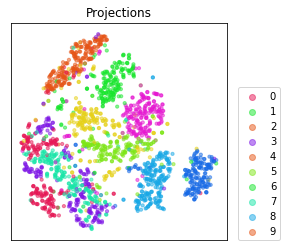

In [3]:
# COLORS are the rgb counterparts of Grid.CMAP_SYN
COLORS = np.array([[0.09, 0.414, 0.9, 0.5],
                   [0.9, 0.333, 0.09, 0.5],
                   [0.09, 0.9, 0.171, 0.5],
                   [0.9, 0.09, 0.819, 0.5],
                   [0.495, 0.09, 0.9, 0.5],
                   [0.495, 0.9, 0.09, 0.5],
                   [0.09, 0.657, 0.9, 0.5],
                   [0.9, 0.09, 0.333, 0.5],
                   [0.9, 0.819, 0.09, 0.5],
                   [0.09, 0.9, 0.657, 0.5]])

y_proj = y_train[:projection_size]
colors = [COLORS[i] for i in y_proj]
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
leg_colors = COLORS[:len(labels)]
plt.title("Projections")

#ax = plt.subplot(121)
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_aspect('equal')
#ax.scatter(Xp_lamp[:, 0], Xp_lamp[:, 1], color=colors, s=10.0)

ax = plt.subplot(111)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
ax.scatter(Xp_tsne[:, 0], Xp_tsne[:, 1], color=colors, s=10.0)


handles = []
for c in colors:
    handles.append(plt.scatter([], [], color=c))
ax.legend(handles, labels, loc="lower left", borderaxespad=0.0, bbox_to_anchor=(1.05, 0))

## iLAMP

Initializing Lamp (kdtree)
	time:  0.002596616744995117
Back projecting
	time:  0.0617525577545166


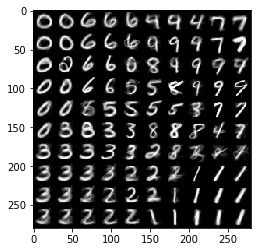

In [11]:
from lamp import ILAMP

def make_img_grid(syn_imgs, N):
    img_grid = np.zeros((N*28, N*28))
    for row in range(N):
        for col in range(N):
            img_grid[row*28:row*28 + 28, (9 - col)*28:(9 - col)*28 + 28] = syn_imgs[N*row + col].reshape((28, 28))
    return img_grid
    

divs = np.linspace(0.0, 1.0, 11)
coords = (divs[:-1] + divs[1:])*0.5
xx, yy = np.meshgrid(coords, coords)
p_coords = np.dstack((xx, yy))
p_coords = np.vstack(p_coords)

N = 10

print("Initializing Lamp (kdtree)")
s = time.time()
ilamp = ILAMP()
ilamp.fit(X_proj, Xp_tsne, n_neighbors=20)
print("\ttime: ", time.time() - s)


print("Back projecting")
s = time.time()
syn_samples_ilamp = ilamp.transform(p_coords, normalize=True)
print("\ttime: ", time.time() - s)

plt.imshow(make_img_grid(syn_samples_ilamp, N), cmap="gray")

In [8]:
joblib.dump(ilamp, "/tmp/ilamp.joblib")

['/tmp/ilamp.joblib']

## NNInv

In [9]:
print("Initializing NNInv)")
s = time.time()
nninv = NNInv()
nninv.fit(X_proj, Xp_tsne)
print("\ttime: ", time.time() - s)

Initializing Lamp (kdtree)
Restoring model weights from the end of the best epoch
Epoch 00172: early stopping
	time:  2708.426771879196


Back projecting
	time:  0.18018746376037598


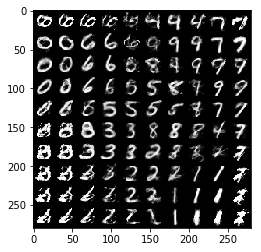

In [10]:
print("Back projecting")
s = time.time()
syn_samples_nninv = nninv.transform(p_coords)
print("\ttime: ", time.time() - s)

plt.imshow(make_img_grid(syn_samples_nninv, N), cmap="gray")

['/tmp/irbf_mp3_mnist.joblib']

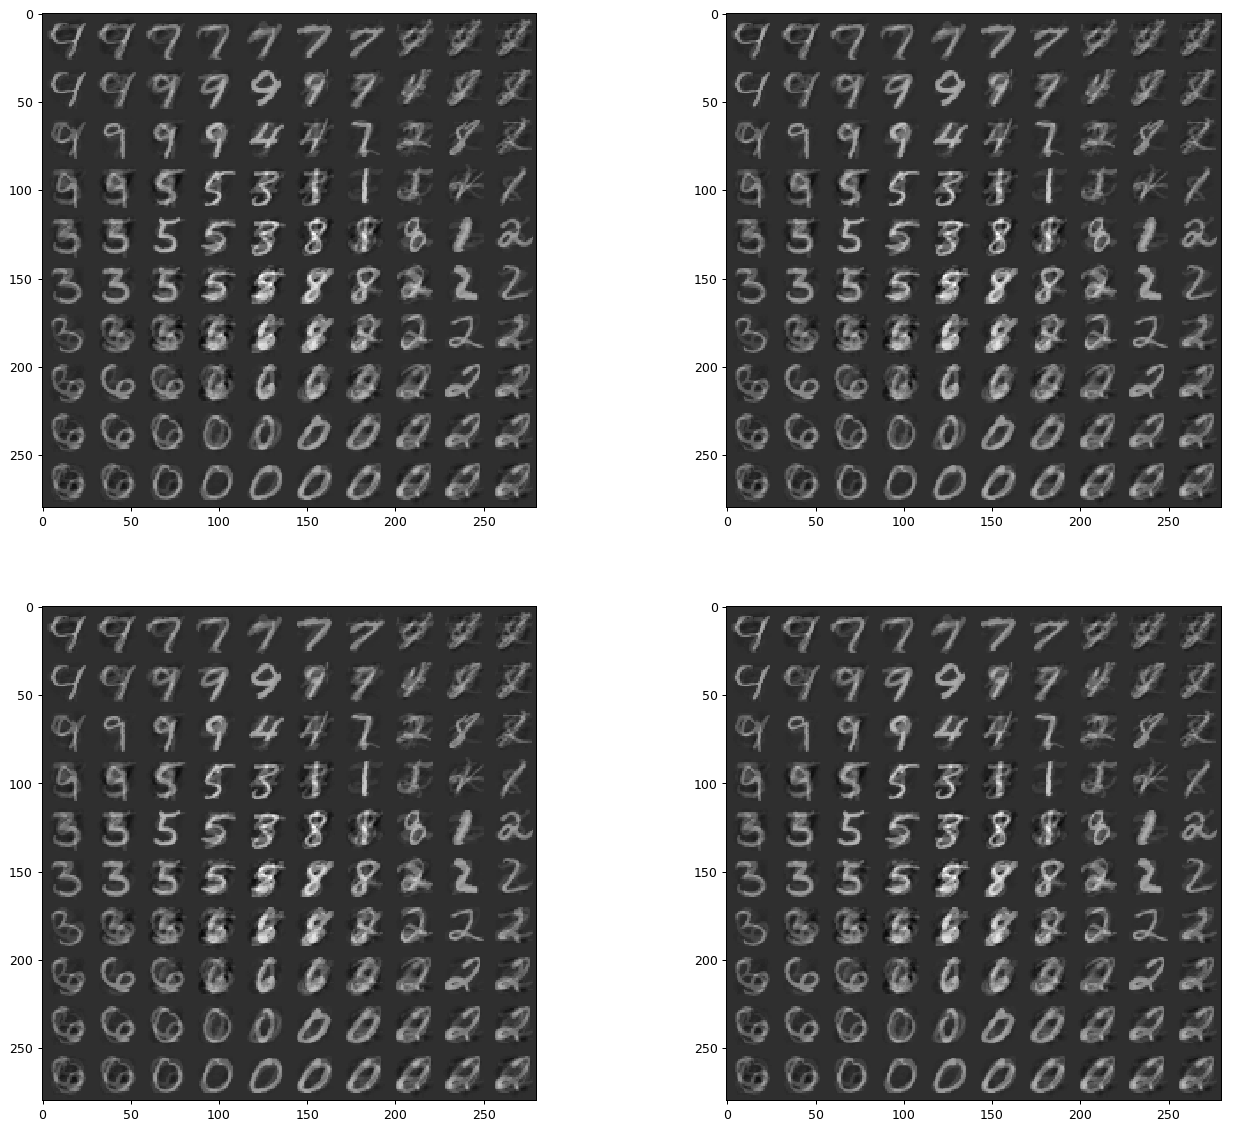

In [10]:
def plot_four(inv0, inv1, inv2, inv3):
    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 16), dpi=90)
    ax[0, 0].imshow(make_img_grid(inv0, N), cmap='gray')
    ax[0, 1].imshow(make_img_grid(inv1, N), cmap='gray')
    ax[1, 0].imshow(make_img_grid(inv2, N), cmap='gray')
    ax[1, 1].imshow(make_img_grid(inv3, N), cmap='gray')
    
plot_four(invmq0, invmq1, invmq2, invmq3)

joblib.dump(irbf_mq3, '/tmp/irbf_mp3_mnist.joblib')

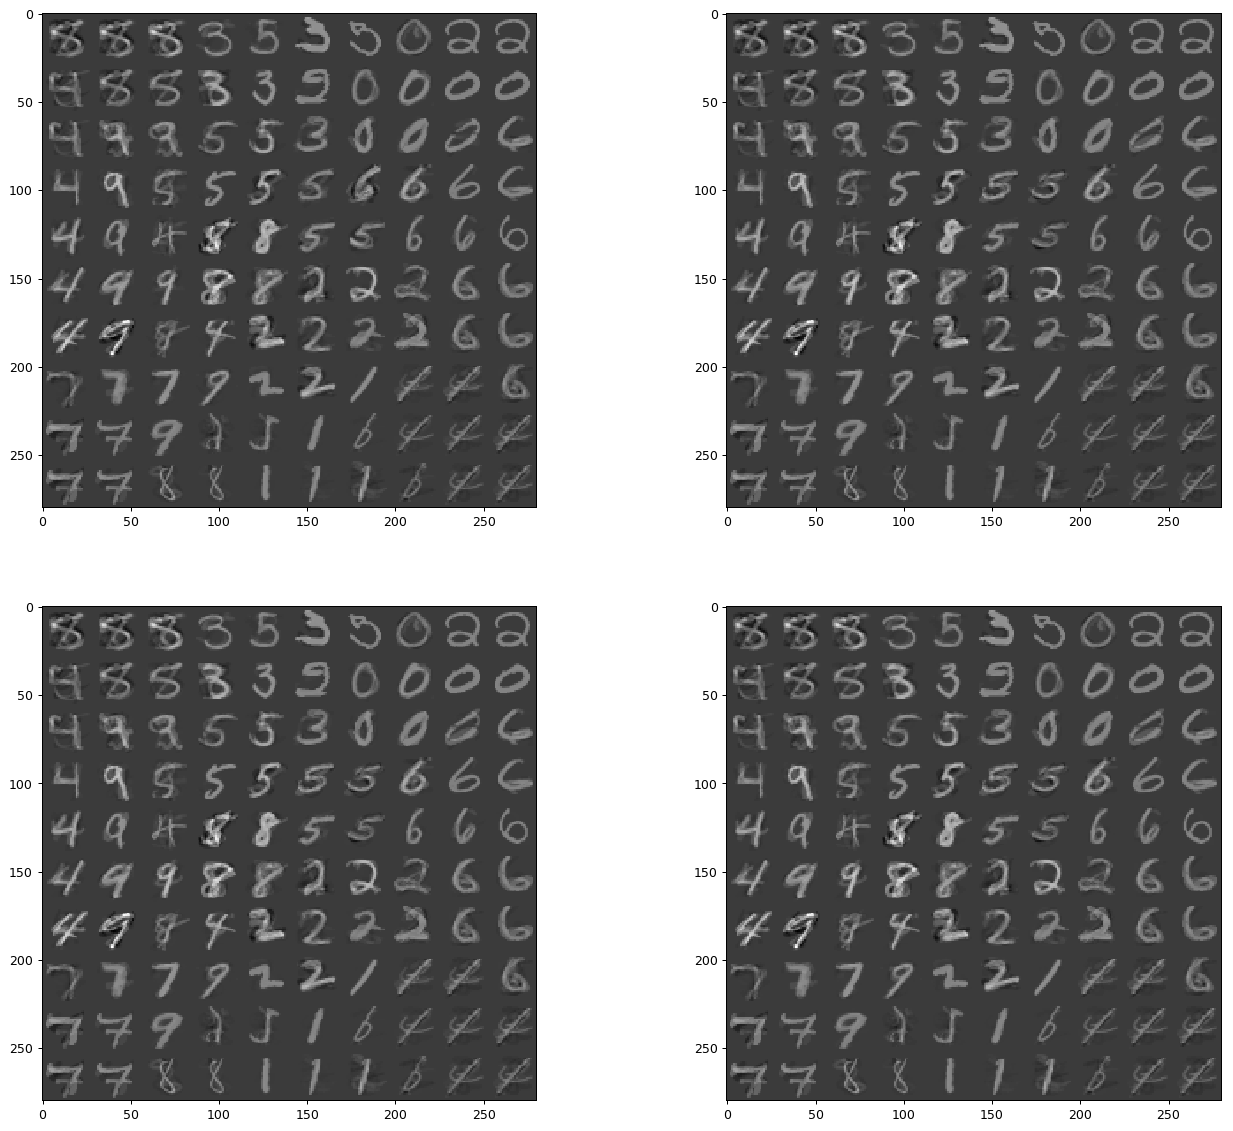

In [15]:
c = 0.0
eps = 1.0
#print("Initializing RBFInv")
#s = time.time()
irbfc_mq0 = RBFInv()
irbfc_mq0.fit(X_proj, Xp_tsne, num_ctrl=100, mode='cluster', kernel=multi_quadrics, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
#print("\ttime: ", time.time() - s)

#print("Back projecting")
#s = time.time()
inv_cmq0 = irbfc_mq0.transform(p_coords)

c = 0.0
eps = 100.0
irbfc_mq1 = RBFInv()
irbfc_mq1.fit(X_proj, Xp_tsne, num_ctrl=100, mode='cluster', kernel=multi_quadrics, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
inv_cmq1 = irbfc_mq1.transform(p_coords)

c = 0.0
eps = 1000.0
irbfc_mq2 = RBFInv()
irbfc_mq2.fit(X_proj, Xp_tsne, num_ctrl=100, mode='cluster', kernel=multi_quadrics, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
inv_cmq2 = irbfc_mq2.transform(p_coords)

c = 0.0
eps = 10000.0
irbfc_mq3 = RBFInv()
irbfc_mq3.fit(X_proj, Xp_tsne, num_ctrl=100, mode='cluster', kernel=multi_quadrics, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
inv_cmq3 = irbfc_mq3.transform(p_coords)

#print("\ttime: ", time.time() - s)
plot_four(inv_cmq0, inv_cmq1, inv_cmq2, inv_cmq3)

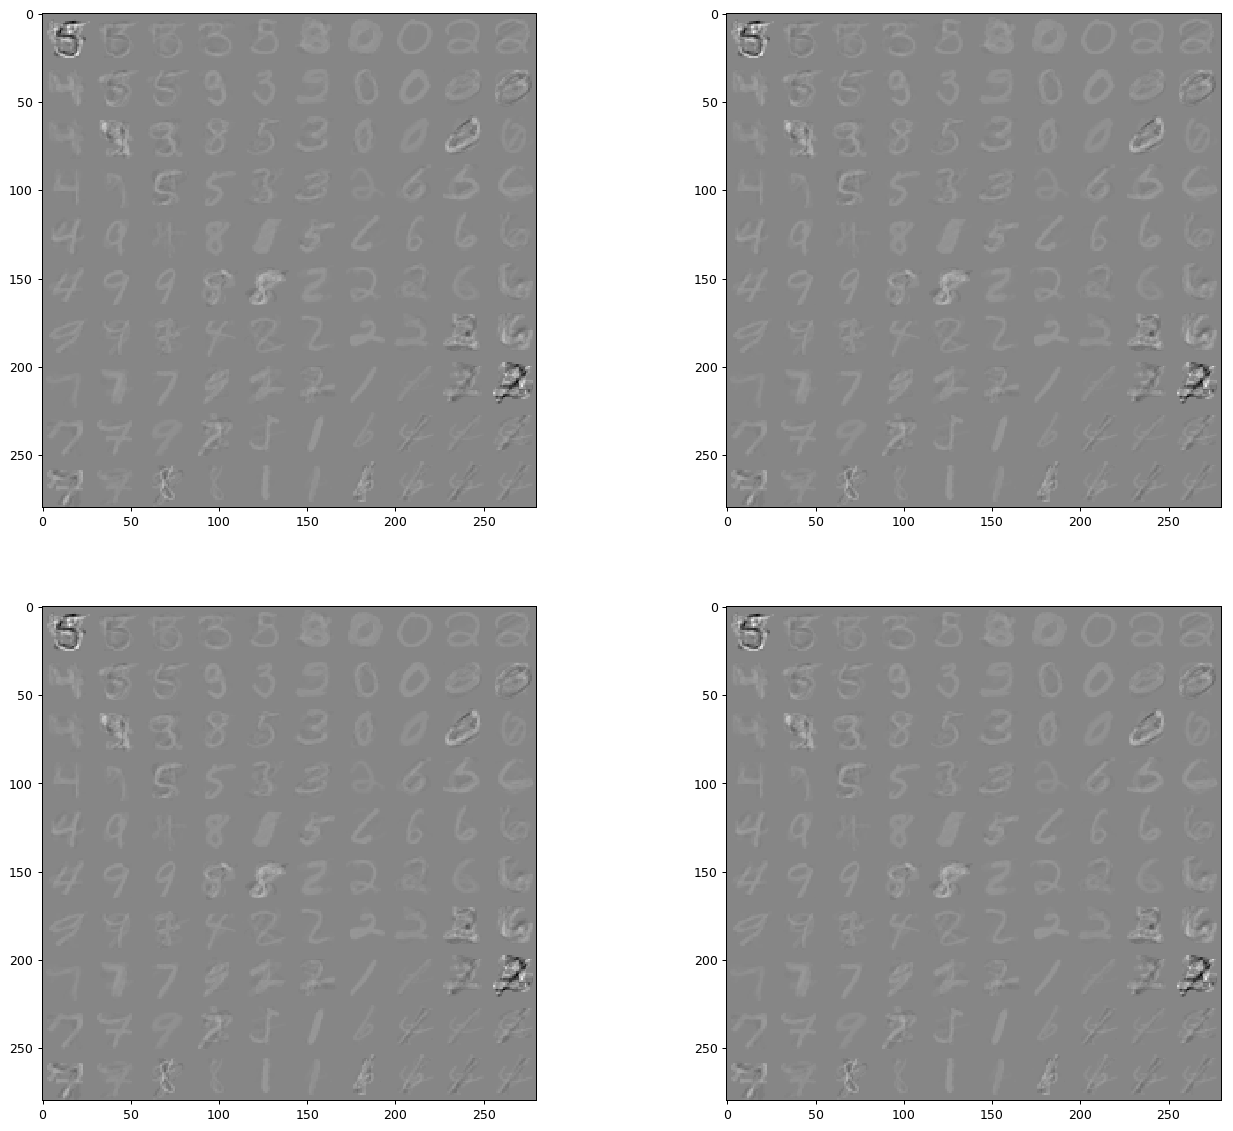

In [17]:
#print("Initializing RBFInv")
#s = time.time()
c = 0.0
eps = 1.0
irbfn_mq0 = RBFInv()
irbfn_mq0.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=multi_quadrics, normalize_c=True, normalize_d=True)
#print("\ttime: ", time.time() - s)

#print("Back projecting")
#s = time.time()
inv_nmq0 = irbfn_mq0.transform(p_coords)

c = 0.0
eps = 100.0
irbfn_mq1 = RBFInv()
irbfn_mq1.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=multi_quadrics, normalize_c=True, normalize_d=True)
inv_nmq1 = irbfn_mq1.transform(p_coords)

c = 0.0
eps = 1000.0
irbfn_mq2 = RBFInv()
irbfn_mq2.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=multi_quadrics, normalize_c=True, normalize_d=True)
inv_nmq2 = irbfn_mq2.transform(p_coords)

c = 0.0
eps = 10000.0
irbfn_mq3 = RBFInv()
irbfn_mq3.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=multi_quadrics, normalize_c=True, normalize_d=True)
inv_nmq3 = irbfn_mq3.transform(p_coords)


plot_four(inv_nmq0, inv_nmq1, inv_nmq2, inv_nmq3)
#print("\ttime: ", time.time() - s)
#plt.imshow(make_img_grid(syn_samples_irbf3, N), cmap='gray')

### Gaussian kernel

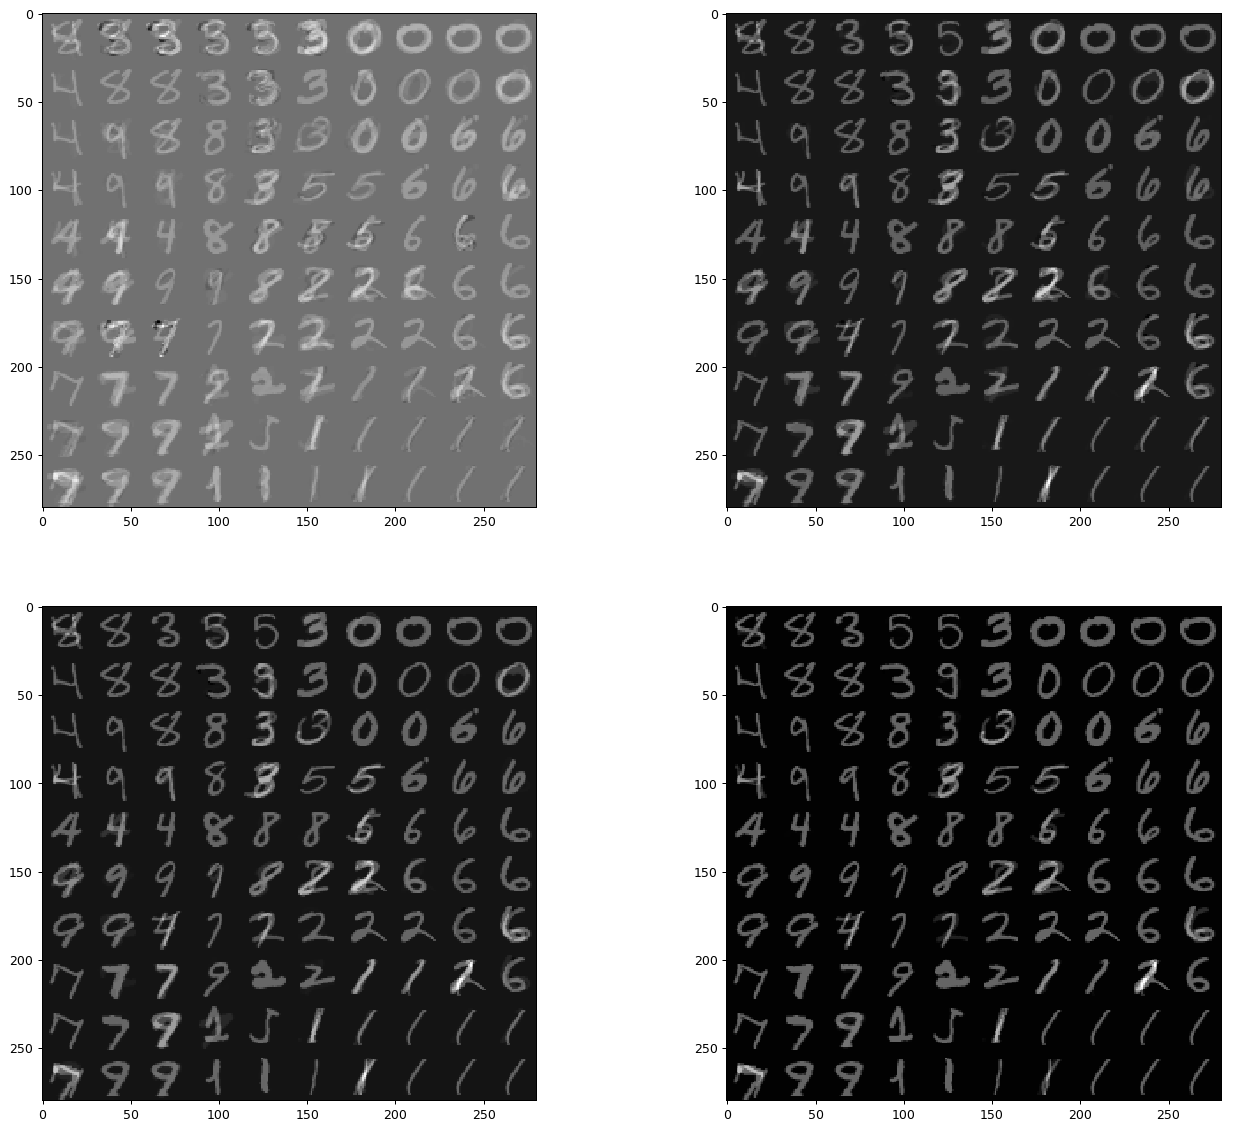

In [19]:
#def gk_4000(r):
#    eps = 4000
#    return np.exp(-(eps*(r**2.0)))

def gaussian(r):
    return np.exp(-(eps*(r**2.0)))

eps = 1000
#print("Initializing RBFInv")
#s = time.time()
irbf_gk0 = RBFInv()
irbf_gk0.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=gaussian, normalize_c=True, normalize_d=True)
#print("\ttime: ", time.time() - s)

#print("Back projecting")
#s = time.time()
inv_gk0 = irbf_gk0.transform(p_coords)
#print("\ttime: ", time.time() - s)

eps = 5000
irbf_gk1 = RBFInv()
irbf_gk1.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=gaussian, normalize_c=True, normalize_d=True)
inv_gk1 = irbf_gk1.transform(p_coords)

eps = 10000
irbf_gk2 = RBFInv()
irbf_gk2.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=gaussian, normalize_c=True, normalize_d=True)
inv_gk2 = irbf_gk2.transform(p_coords)

eps = 50000
irbf_gk3 = RBFInv()
irbf_gk3.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=gaussian, normalize_c=True, normalize_d=True)
inv_gk3 = irbf_gk3.transform(p_coords)


#plt.imshow(make_img_grid(syn_samples_irbf4, N), cmap='gray')
plot_four(inv_gk0, inv_gk1, inv_gk2, inv_gk3)

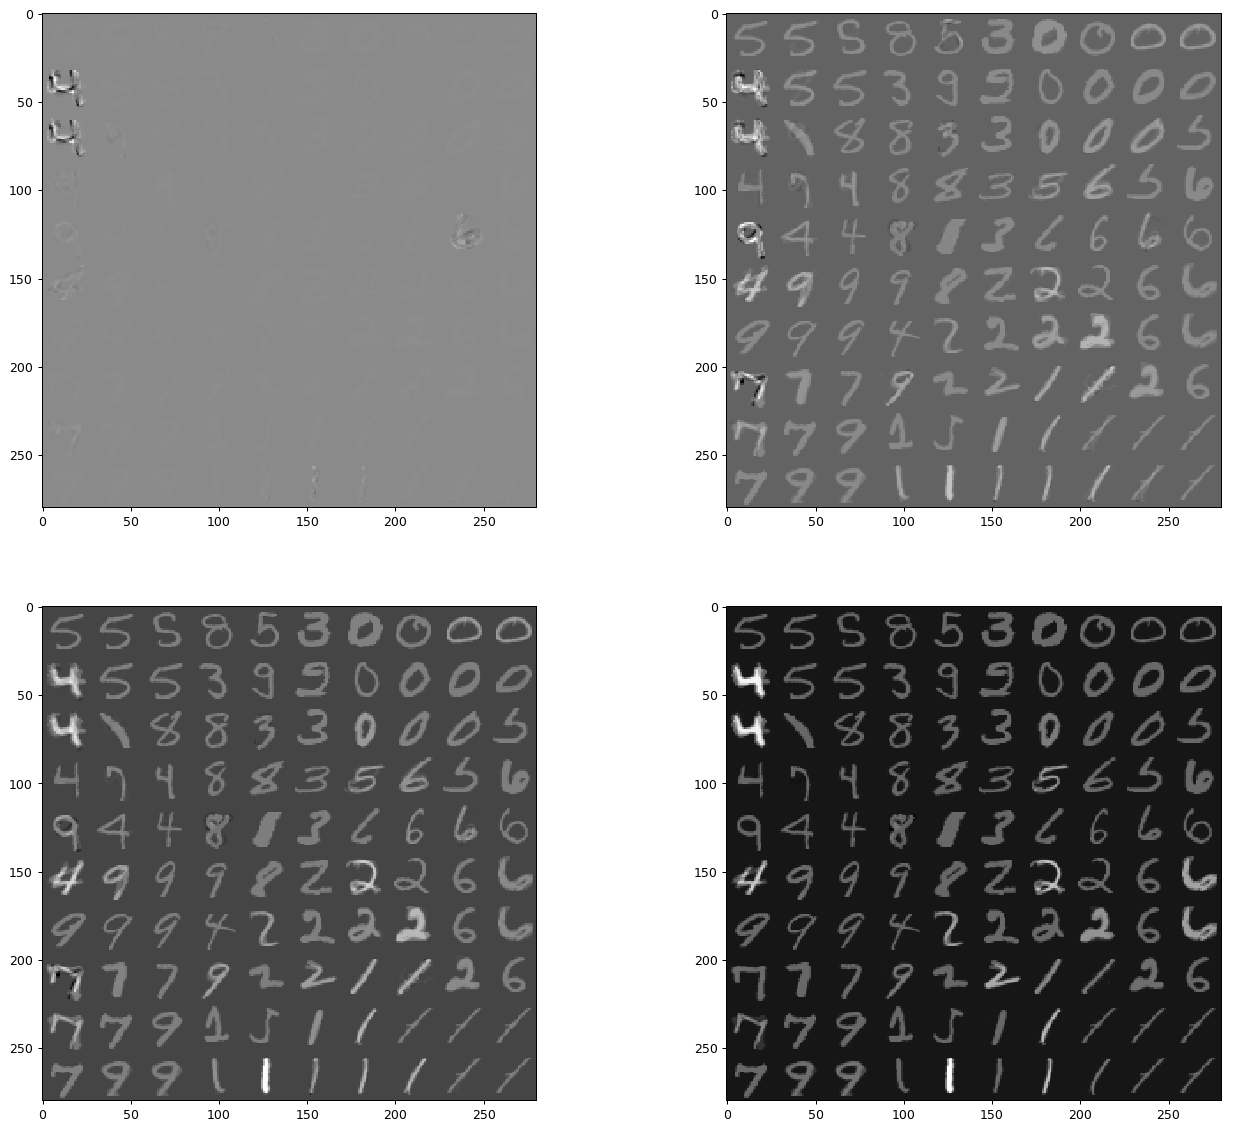

In [20]:
#print("Initializing RBFInv")
#s = time.time()
eps = 1000
irbfc_gk0 = RBFInv()
irbfc_gk0.fit(X_proj, Xp_tsne, num_ctrl=120, mode='cluster', kernel=gaussian, normalize_c=True, normalize_d=True)
#print("\ttime: ", time.time() - s)

#print("Back projecting")
#s = time.time()
invc_gk0 = irbfc_gk0.transform(p_coords)
#print("\ttime: ", time.time() - s)


eps = 5000
irbfc_gk1 = RBFInv()
irbfc_gk1.fit(X_proj, Xp_tsne, num_ctrl=120, mode='cluster', kernel=gaussian, normalize_c=True, normalize_d=True)
invc_gk1 = irbfc_gk1.transform(p_coords)

eps = 10000
irbfc_gk2 = RBFInv()
irbfc_gk2.fit(X_proj, Xp_tsne, num_ctrl=120, mode='cluster', kernel=gaussian, normalize_c=True, normalize_d=True)
invc_gk2 = irbfc_gk2.transform(p_coords)

eps = 50000
irbfc_gk3 = RBFInv()
irbfc_gk3.fit(X_proj, Xp_tsne, num_ctrl=120, mode='cluster', kernel=gaussian, normalize_c=True, normalize_d=True)
invc_gk3 = irbfc_gk3.transform(p_coords)

plot_four(invc_gk0, invc_gk1, invc_gk2, invc_gk3)
#plt.imshow(make_img_grid(syn_samples_irbf5, N), cmap='gray')

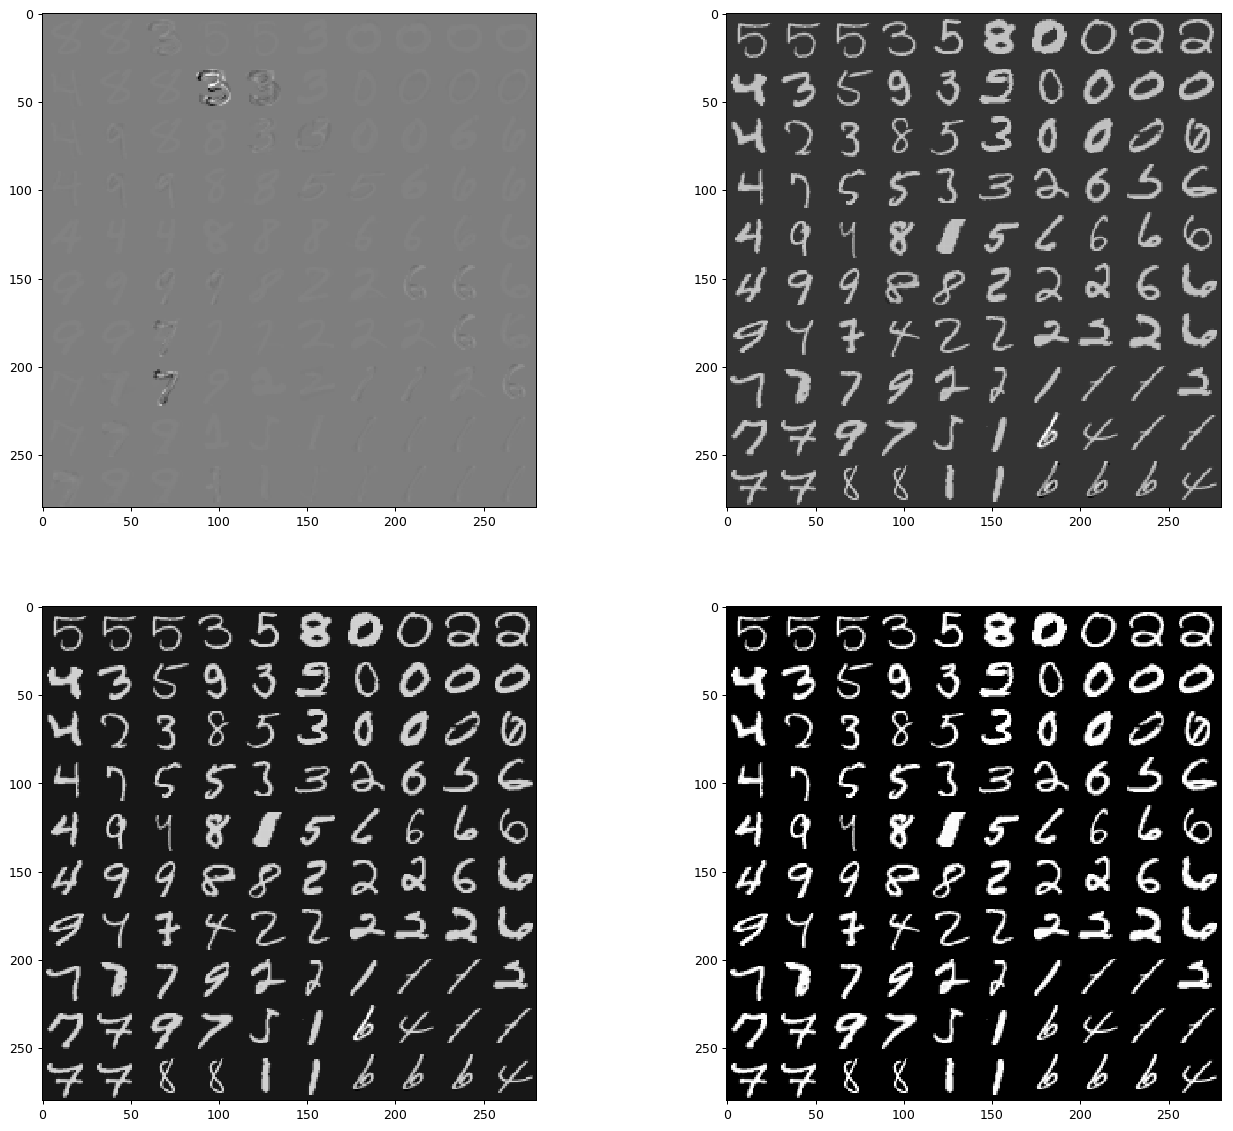

In [25]:
eps = 100000
#print("Initializing RBFInv")
#s = time.time()
irbfn_gk0 = RBFInv()
irbfn_gk0.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=gaussian, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
#print("\ttime: ", time.time() - s)
#print("Back projecting")
#s = time.time()
invn_gk0 = irbf_gk0.transform(p_coords)


eps = 500000
irbfn_gk1 = RBFInv()
irbfn_gk1.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=gaussian, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
invn_gk1 = irbfn_gk1.transform(p_coords)

eps = 1000000
irbfn_gk2 = RBFInv()
irbfn_gk2.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=gaussian, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
invn_gk2 = irbfn_gk2.transform(p_coords)


eps = 5000000
irbfn_gk3 = RBFInv()
irbfn_gk3.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=gaussian, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
invn_gk3 = irbfn_gk3.transform(p_coords)


plot_four(invn_gk0, invn_gk1, invn_gk2, invn_gk3)

### Inverse Multiquadrics

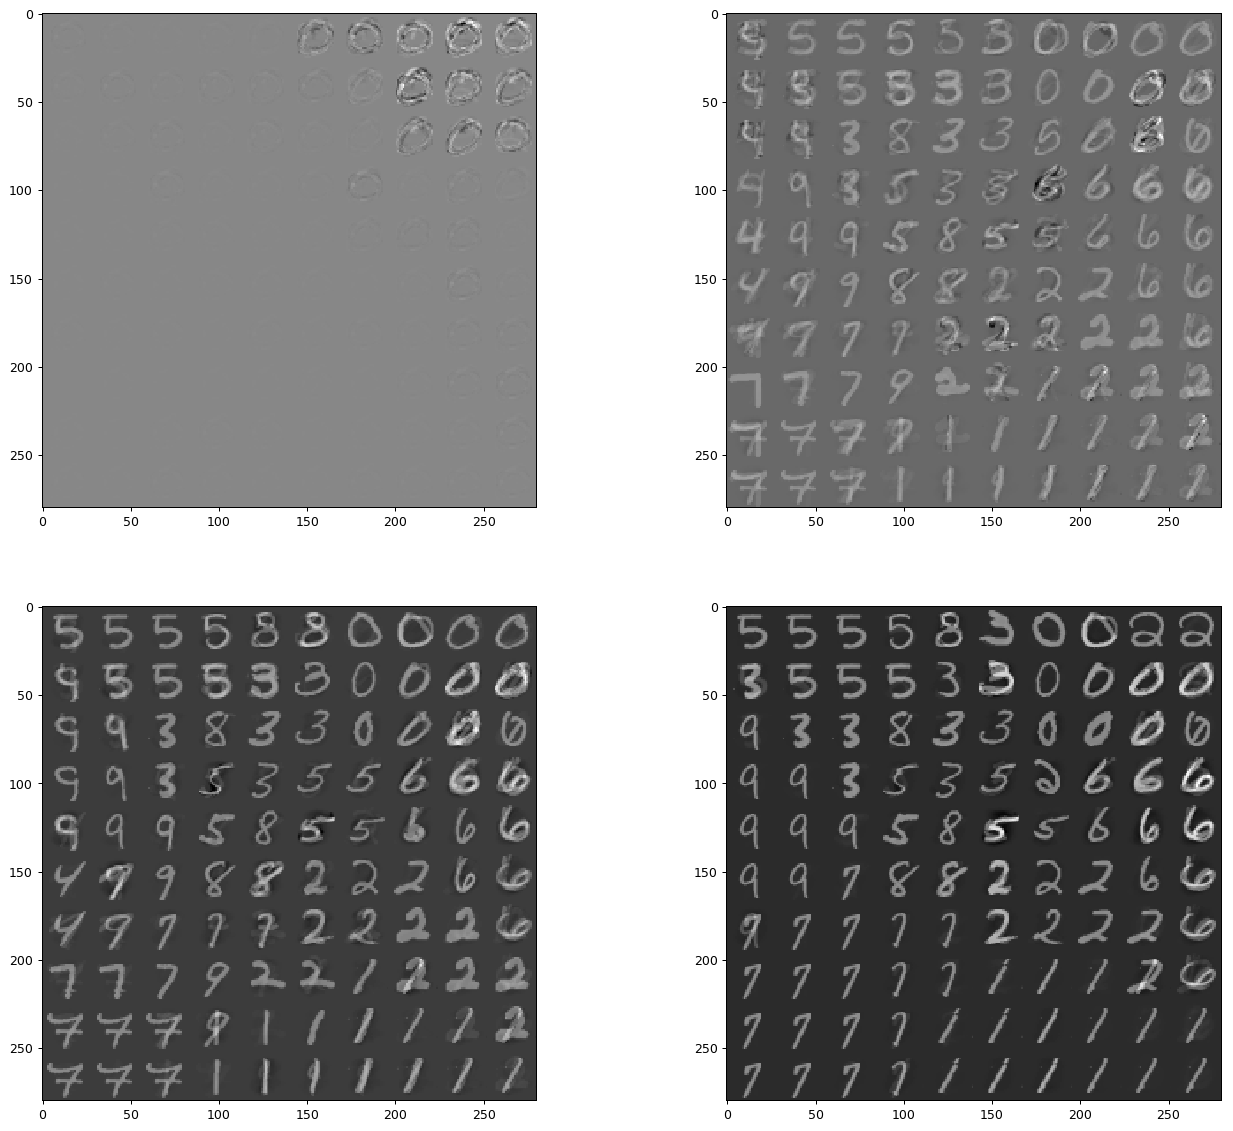

In [31]:
def inv_mq(r):
    return 1.0/np.sqrt(c + eps*(r**2))

c = 1.0
eps = 100.0
irbf_imq0 = RBFInv()
irbf_imq0.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=inv_mq, normalize_c=True, normalize_d=True, 
         reg_coef=0.0)
# print("\ttime: ", time.time() - s)

#print("Back projecting")
#s = time.time()
invimq0 = irbf_imq0.transform(p_coords)
#print("\ttime: ", time.time() - s)

c = 1.0
eps=1000.0
irbf_imq1 = RBFInv()
irbf_imq1.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=inv_mq, normalize_c=True, normalize_d=True, 
         reg_coef=0.0)
invimq1 = irbf_imq1.transform(p_coords)

c = 1.0
eps=10000.0
irbf_imq2 = RBFInv()
irbf_imq2.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=inv_mq, normalize_c=True, normalize_d=True, 
         reg_coef=0.0)
invimq2 = irbf_imq2.transform(p_coords)

c = 1.0
eps=100000.0
irbf_imq3 = RBFInv()
irbf_imq3.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=inv_mq, normalize_c=True, normalize_d=True, 
         reg_coef=0.0)
invimq3 = irbf_imq3.transform(p_coords)

plot_four(invimq0, invimq1, invimq2, invimq3)

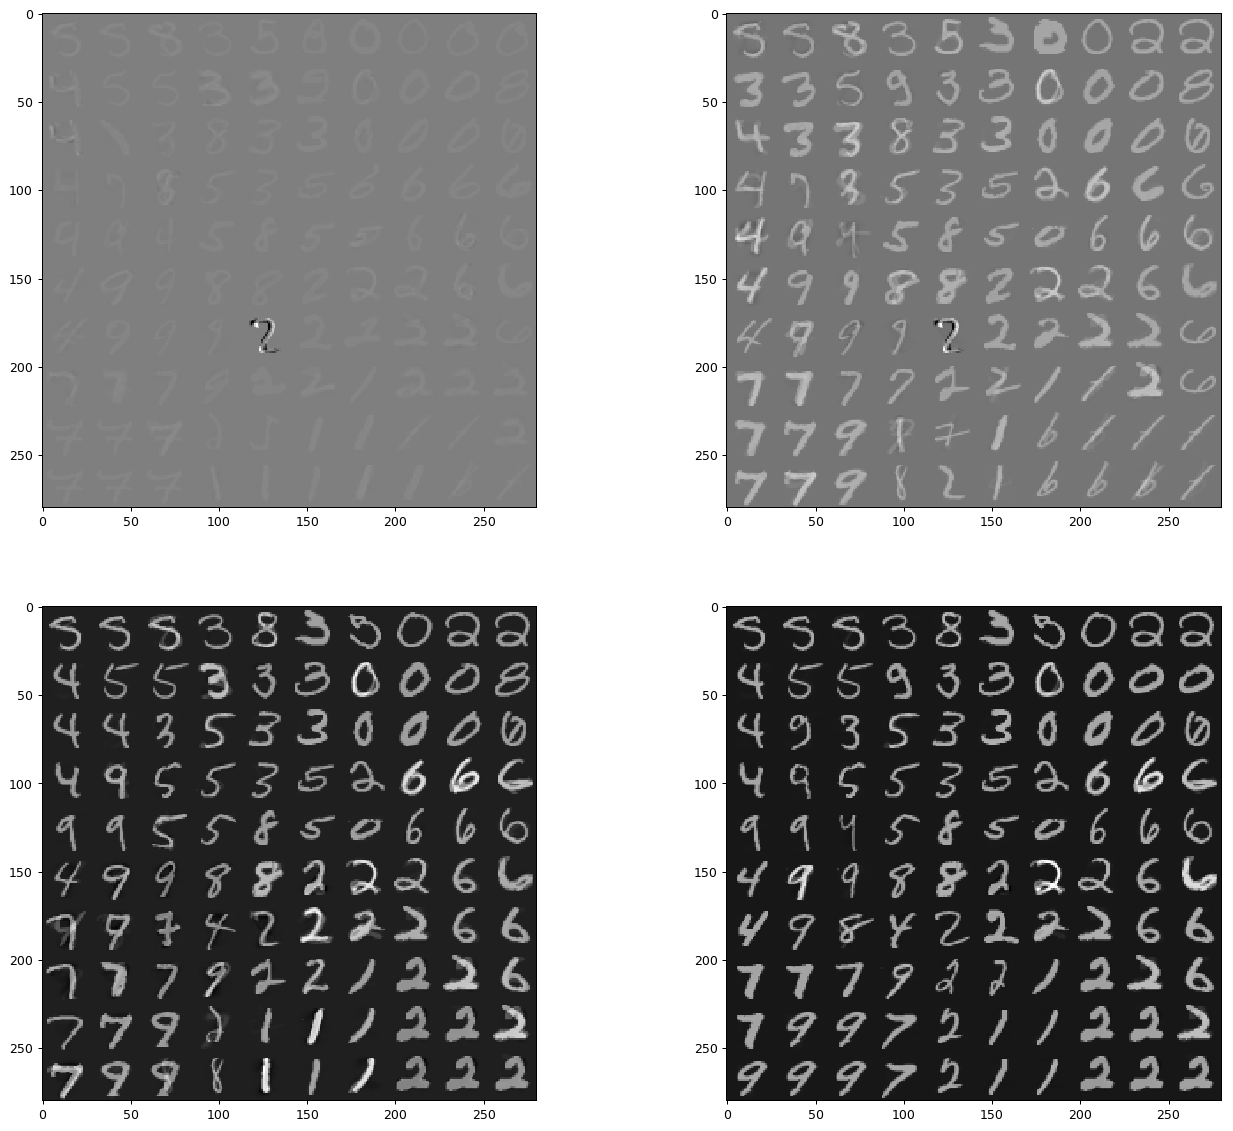

In [34]:
c = 1.0
eps = 10000.0
#print("Initializing RBFInv")
#s = time.time()
irbfc_imq0 = RBFInv()
irbfc_imq0.fit(X_proj, Xp_tsne, num_ctrl=100, mode='cluster', kernel=inv_mq, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
#print("\ttime: ", time.time() - s)

#print("Back projecting")
#s = time.time()
inv_cimq0 = irbfc_imq0.transform(p_coords)

c = 1.0
eps = 100000.0
irbfc_imq1 = RBFInv()
irbfc_imq1.fit(X_proj, Xp_tsne, num_ctrl=100, mode='cluster', kernel=inv_mq, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
inv_cimq1 = irbfc_imq1.transform(p_coords)

c = 1.0
eps = 1000000.0
irbfc_imq2 = RBFInv()
irbfc_imq2.fit(X_proj, Xp_tsne, num_ctrl=100, mode='cluster', kernel=inv_mq, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
inv_cimq2 = irbfc_imq2.transform(p_coords)

c = 1.0
eps = 10000000.0
irbfc_imq3 = RBFInv()
irbfc_imq3.fit(X_proj, Xp_tsne, num_ctrl=100, mode='cluster', kernel=inv_mq, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
inv_cimq3 = irbfc_imq3.transform(p_coords)

#print("\ttime: ", time.time() - s)
plot_four(inv_cimq0, inv_cimq1, inv_cimq2, inv_cimq3)

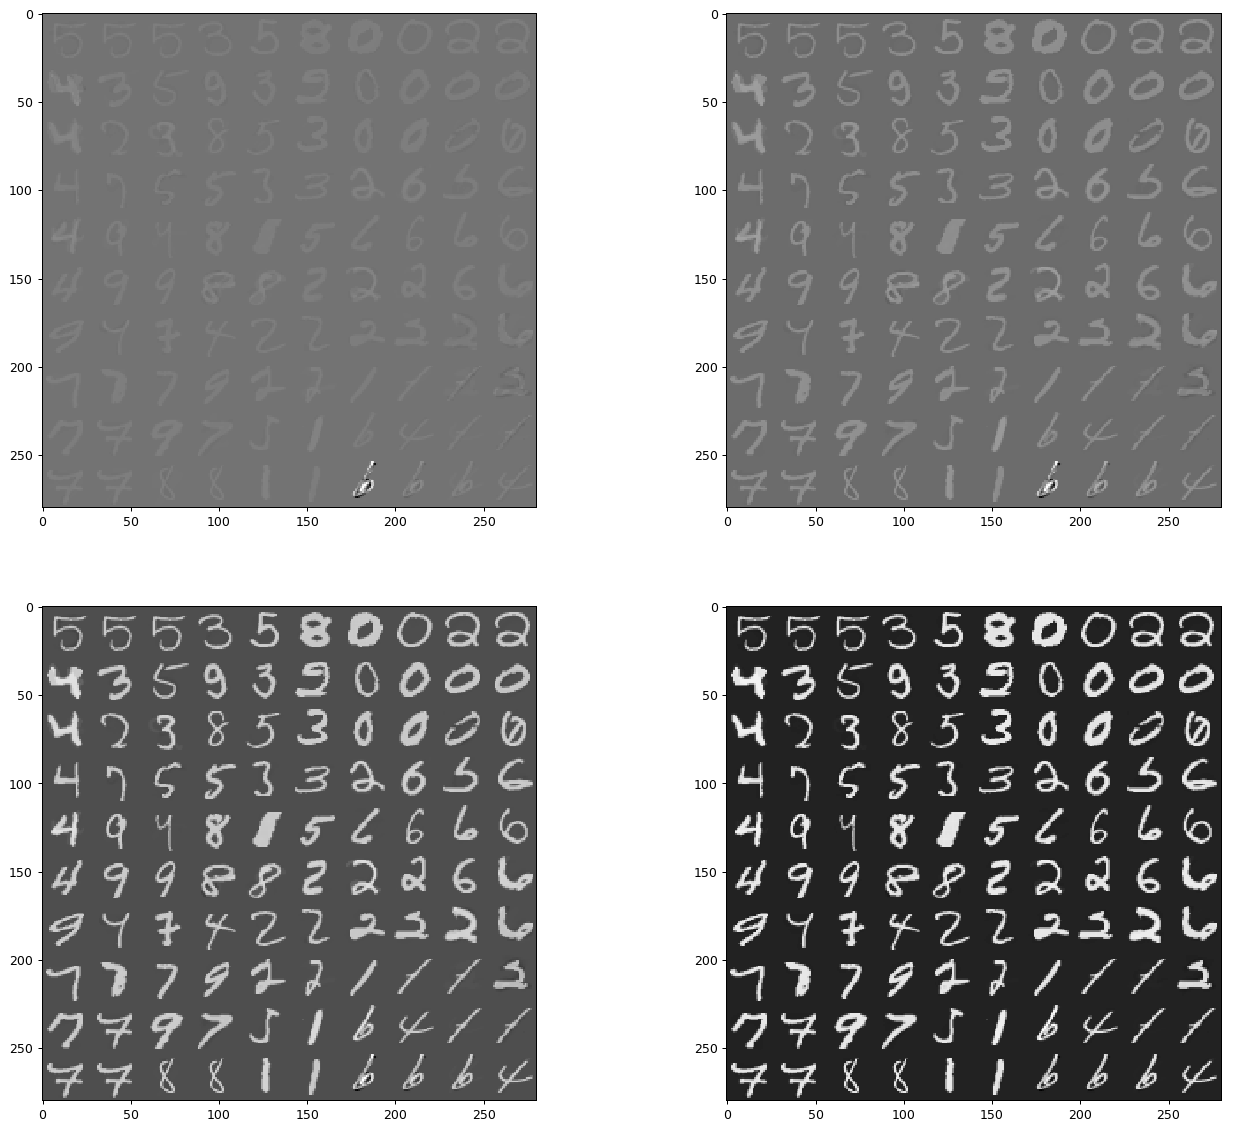

In [37]:
#print("Initializing RBFInv")
#s = time.time()
c = 1.0
eps = 10000.0
irbfn_imq0 = RBFInv()
irbfn_imq0.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=inv_mq, normalize_c=True, normalize_d=True)
#print("\ttime: ", time.time() - s)

#print("Back projecting")
#s = time.time()
inv_nimq0 = irbfn_imq0.transform(p_coords)

c = 1.0
eps = 100000.0
irbfn_imq1 = RBFInv()
irbfn_imq1.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=inv_mq, normalize_c=True, normalize_d=True)
inv_nimq1 = irbfn_imq1.transform(p_coords)

c = 1.0
eps = 1000000.0
irbfn_imq2 = RBFInv()
irbfn_imq2.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=inv_mq, normalize_c=True, normalize_d=True)
inv_nimq2 = irbfn_imq2.transform(p_coords)

c = 1.0
eps = 10000000.0
irbfn_imq3 = RBFInv()
irbfn_imq3.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=inv_mq, normalize_c=True, normalize_d=True)
inv_nimq3 = irbfn_imq3.transform(p_coords)


plot_four(inv_nimq0, inv_nimq1, inv_nimq2, inv_nimq3)